In [1]:
from nd2tif.transform import to_8bits

In [218]:
from nd2_combine import tools
from segment import seg
from droplet_growth import multiwell
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import math
import pandas as pd
import re
from skimage.morphology import convex_hull_image
from skimage.transform import rotate
from scipy.ndimage import gaussian_filter1d as gf
from scipy.interpolate import interp1d
import seaborn as sns
from tifffile import imread
import json
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PX_SIZE_UM = 1.6

In [7]:
dirr = fluo_path.replace('.nd2','')
try:
    os.mkdir(dirr)
except FileExistsError:
    pass

In [5]:
def to_rgb(stack, order, 
    ch = {'r': 'TRITC', 'g': 'FITC', 'b': 'DAPI'}
):
    stack8 = stack#to_8bits(stack)
#     print(stack8.shape, stack8.dtype)
    rgb = np.stack([stack8[order.index(v)] for v in ch.values()], axis=-1)
#     print(rgb.shape)
#     multiwell.show(rgb)
    

In [6]:
class MultiColorWell:
    def __init__(self, stack_cyx:np.ndarray, 
                 order:list, colors={'r': 'TRITC', 'g': 'FITC', 'b': 'DAPI'}):
        stack = stack_cyx
        assert stack.ndim == 3
        self.original_stack = stack
        assert [color in order for color in colors.values()]
        stack_order = [order.index(v) for v in colors.values()]
        self.colors = colors
        self.rgb = np.stack(to_8bits(stack)[stack_order], axis=-1)
        
    def __repr__(self):
        multiwell.show(self.rgb)
        multiwell.plt.title(self.colors)
        multiwell.plt.show()
        return f'rgb {self.rgb.shape}'
                        
        
        

In [7]:
# from pims_nd2 import ND2_Reader as nd
from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='yx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
        channels = frames.metadata['channels']
        print(channels)
        px_size_um = frames.metadata['pixel_microns']
        frames.iter_axes = 'v'
        frames.default_coords['z'] = 0
        frames.bundle_axes = bundle_axes
#         if well_index is not None:
#             yield frames[well_index]
#         else:
        for f in frames:
            yield f#MultiColorWell(f, channels)

In [8]:
from pims_nd2 import ND2_Reader as nd
# from nd2reader import ND2Reader as nd

def read_nd2(path:str, bundle_axes='yx', pos_limit=None, well_index=None):
    logger.debug(f'read_nd2: open {path}')
    with nd(path,) as frames:
        print(frames.sizes)
        channels = [
            frames.metadata[f'plane_{i}']['name'] for i in range(
                frames.sizes['c']
            )
        ]
        print(channels)
        px_size_um = frames.calibration
        frames.iter_axes = 'm'
        frames.bundle_axes = bundle_axes
        for f in frames:
            yield MultiColorWell(f, channels)

In [122]:
def filter_regions(r, maj_len=(300, 200), ecc=(0.4, 0.4), convex_area_tolerance=.1):
    return   (r.major_axis_length > maj_len[0] - maj_len[1] and 
              r.major_axis_length < maj_len[0] + maj_len[1] and
              r.eccentricity > ecc[0] - ecc[1] and
              r.eccentricity < ecc[0] + ecc[1] and
              r.convex_area - r.area < r.area * convex_area_tolerance
             )


def get_intensity(mask, intensity_image):
    props = multiwell.regionprops(
        mask,
        intensity_image=intensity_image
    )
#     print(f'MALs: {[p.major_axis_length for p in props]}')
#     print(f'eccs: {[p.eccentricity for p in props]}')
    f_props = list(filter(filter_regions, props))
    print(f'{len(f_props)} after filtering')
    return f_props


def decompose_RGB(rgb_stack):
    tritc = rgb_stack[:,:,0]
    fitc = rgb_stack[:,:,1]
    dapi = rgb_stack[:,:,2]
    return tritc, fitc, dapi
    

def segment_multichannel(rgb_stack:MultiColorWell, thr=0.15, smooth=10, erode=20):
    
    tritc, fitc, dapi = decompose_RGB(rgb_stack)
    
    segs = segment_bf(dapi, thr=thr, smooth=smooth, erode=erode)
    
    crops = map(lambda img: get_intensity(segs.mask, img), (tritc, fitc, dapi))
    
    fig, ax = multiwell.plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(rgb_stack)
    ax[1].imshow(segs.mask)
    multiwell.plt.show()
    
    result = {
              'profiles_axis': 'major_axis',
              'organoids': {}
             }

    for index, (r, g, b) in enumerate(zip(*crops)):
        
        rotated_crops = [rotate(
            props.intensity_image,
            -props.orientation / math.pi * 180 - 90,
#             center= r.local_centroid,
            resize=True
        ) for props in (r,g,b)]
        
        intensity_profiles = {color: {
            'mean': list(crop.mean(axis=0).astype('float16')),
            'max': list(crop.max(axis=0).astype('float16'))}
                            for crop,color in zip(
                                rotated_crops,
                                rgb_stack.colors.keys()
                            )
                        }
        
        result['organoids'][index] = {
            'centroid_yx': r.centroid,
#             'coords': list(r.coords),
            'major_axis_length': int(r.major_axis_length),
            'eccentricity': np.round(r.eccentricity, 2),
            'orientation': np.round(r.orientation, 2),
            'intensity_profiles': intensity_profiles,
        }
        
        print(f'MAL {r.major_axis_length}, ecc {r.eccentricity}')
        y0,x0 = r.local_centroid
        y,x = r.weighted_local_centroid
        
        fig, ax = multiwell.plt.subplots(1,4, figsize=(10,3), dpi=150)
        
        ax[0].imshow(b.intensity_image)
        plot_axes(r, ax[0])
        ax[0].plot(x0, y0, 'bx')
        ax[0].plot(x,y, 'rx')
        ax[0].set_title('DAPI')
               
        
        ax[1].imshow(np.stack(rotated_crops, axis=-1))
        ax[1].set_title('x-aligned')
        
        [ax[2].plot(
            crop.mean(axis=0)/crop.mean(axis=0).max(),
            fmt,
            label=color
        ) for crop, (fmt, color) in zip(
            rotated_crops,
            rgb_stack.colors.items()
        )]
        ax[2].legend()
        ax[2].set_title('x mean projection')
        
        [ax[3].plot(
            crop.max(axis=0)/crop.max(),
            fmt,
            label=color,
            lw=0.5
        ) for crop, (fmt, color) in zip(
            rotated_crops,
            rgb_stack.colors.items()
        )]
        ax[3].legend()
        ax[3].set_title('x max projection')
        
    return result
    
def plot_axes(props, ax):
    y0, x0 = props.local_centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)
    ax.set_title(f'angle {orientation}')

#     minr, minc, maxr, maxc = props.bbox
#     bx = (minc, maxc, maxc, minc, minc)
#     by = (minr, minr, maxr, maxr, minr)
#     ax.plot(bx, by, '-b', linewidth=2.5)

In [123]:
class SegmentedImage:
    
    def __init__(self, raw_image, mask, crop=None):
        self.raw_image = raw_image
        self.mask = mask
        self.crop=crop

In [212]:
def segment_bf(well, thr=0.2, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} regions')
    if plot:
        fig, ax = multiwell.plt.subplots(1,2)
        ax[0].imshow(sm, cmap='gray')
        ax[1].imshow(labels)
        plt.show()
        
    return SegmentedImage(well, labels)


In [213]:
def read_tif(path, channels:list = ['PAX6', 'BRA', 'DAPI'], order:list='grb') -> MultiColorWell:
    stack = imread(path)
    stack8 = to_8bits(stack)
    print(path)
    print(stack8.shape)
    colors='rgb'
    assert len(stack8) == len(colors)
    _order = [order.index(c) for c in colors]
    rgb = np.stack(stack8[_order], axis=-1)
    plt.imshow(rgb)
    plt.show()
    return {'path': path, 'stack': stack8[_order], 'rgb': rgb}

In [229]:
def subsample_intensity_profile(values, n_samples=10, sigma=10, plot=False):
    '''
    Subsamples 1D curve.
    1. Cut off zero values
    2. Smooth with `sigma`
    3. Intepolate using vector with `n_samples` spots
    
    Return:
    -------
    Subsampled values
    '''
    r_profile = np.array(values, 'float')
    rf_profile = r_profile[r_profile > 0]
    rfs_profile = gf(rf_profile, sigma)
    full_vector = np.arange(len(rfs_profile))
    approx = interp1d(full_vector, rfs_profile)
    vector = np.linspace(0, len(rfs_profile)-1, n_samples, endpoint=True)
    subsample = approx(vector)
    
    if plot:
        plt.plot(rf_profile)
        plt.plot(rfs_profile)
        plt.plot(vector, subsample, '.r')
        plt.show()
    return subsample

def orient(curve):
    curve = curve / curve.max()
    mid = len(curve) // 2
    if curve.argmax() < mid:
        return curve[::-1]
    else:
        return curve
    
def process_3_colors(stack:dict, min_size=50, bins=20, staining=['PAX', 'BRA']):
    path, stack, rgb = stack.values()
    bra, pax, dapi = stack
    print('DAPI')
    labels = segment_bf(dapi, plot=1)
    props = multiwell.regionprops(labels.mask)
    prop = list(filter(lambda p: p.major_axis_length > min_size, props))[0]
    mask = labels.mask == prop.label
    good_mask = convex_hull_image(mask).astype(int)
    orientation = multiwell.regionprops(good_mask)[0].orientation
    
    plt.imshow(good_mask)
    plt.title('Convex area')
    plt.show()
    
    vector = np.linspace(-.5, .5, bins)
    data = {'bins': vector, 
            'path': path, 
            'size_px': props[0].major_axis_length,
    }
    prop_index=0
    
    for img, ch  in zip([pax, bra], staining):
        print(ch)
        crop = img * good_mask
        aligned = rotate(
            crop,
            -orientation / math.pi * 180 - 90,
            resize=True
        )
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
        ax1.imshow(aligned, cmap='gray')
        
        profile = aligned.max(axis=0)
        binned_profile = subsample_intensity_profile(profile, bins)
        
        binned_profile = binned_profile - binned_profile.min()
        binned_profile = binned_profile/binned_profile.max()
        
        ax2.plot(binned_profile)
        plt.show()
        
        data[ch] = binned_profile
    if data[staining[1]].argmax() > bins // 2:
        data[staining[1]] = data[staining[1]][::-1]
        data[staining[0]] = data[staining[0]][::-1]
    profiles = pd.DataFrame(data)
    return profiles

In [ ]:
flist = glob(fluo_path+'*.tif')
for f in flist[:3]:
    print(f)
    rgb = read_tif(f)
    process_3_colors(rgb)

In [ ]:
profiles = list(map(lambda path: process_3_colors(read_tif(path)), flist))

In [175]:
df = pd.concat(profiles)

Text(0.5, 1.0, 'Intensity profiles along major axis')

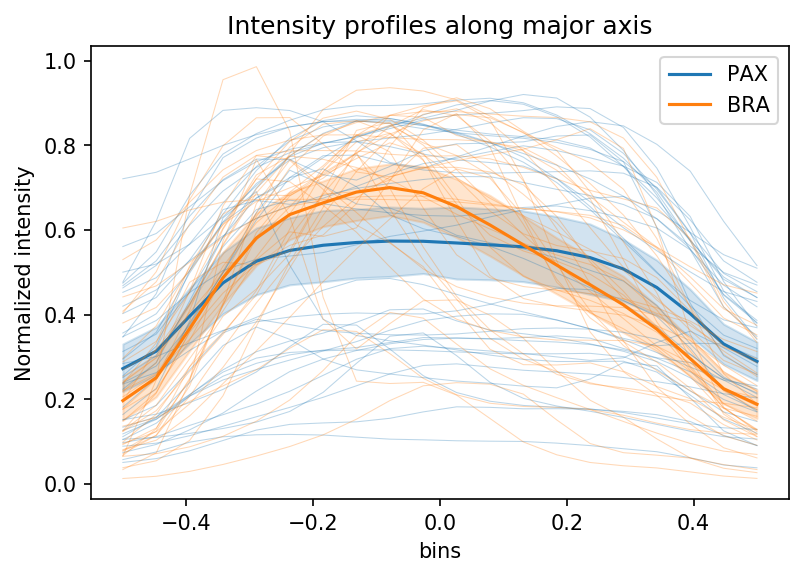

In [195]:
plt.subplots(dpi=150)
sns.lineplot(x='bins', y='PAX', data=df, label='PAX', color='tab:blue')
sns.lineplot(x='bins', y='PAX', data=df, estimator=None, units='path', color='tab:blue', alpha=.3, lw=.5)

sns.lineplot(x='bins', y='BRA', data=df, label='BRA', color='tab:orange')
sns.lineplot(x='bins', y='BRA', data=df, estimator=None, units='path', color='tab:orange', alpha=.3, lw=.5)
# 
# sns.lineplot(x='bins', y='BRA', data=df, label='BRA')
plt.legend()
plt.ylabel('Normalized intensity')
plt.title('Intensity profiles along major axis')


../data-Seb/SUMO3/D5_BRA_PAX6/11.tif
(3, 591, 612)


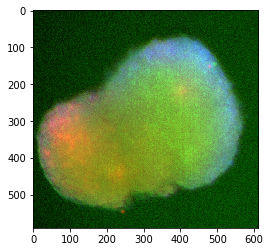

DAPI
2 regions


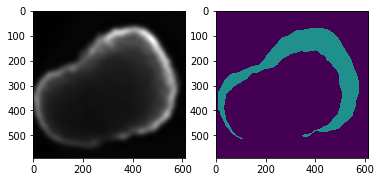

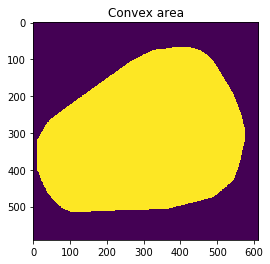

PAX


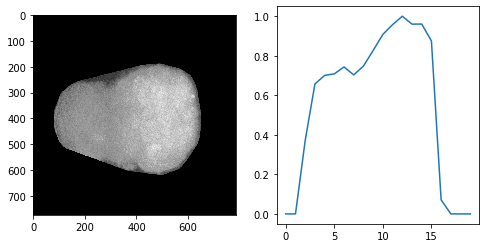

BRA


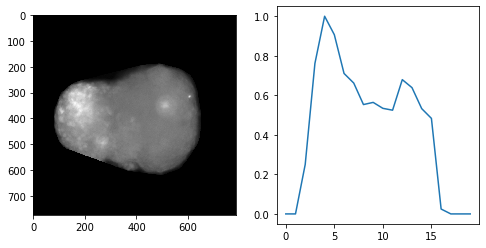

bins                                  path     size_px       PAX  \
0  -0.500000  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.000000   
1  -0.447368  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.000016   
2  -0.394737  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.371996   
3  -0.342105  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.657111   
4  -0.289474  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.700930   
5  -0.236842  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.708551   
6  -0.184211  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.743523   
7  -0.131579  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.703416   
8  -0.078947  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.747989   
9  -0.026316  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.827027   
10  0.026316  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.908163   
11  0.078947  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.957593   
12  0.131579  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  1.000000   
13  0.184211  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.960057   
14  0.236842  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.960554   
15  0.289474  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.875037   
16  0.342105  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.071256   
17  0.394737  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.000000   
18  0.447368  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.000000   
19  0.500000  ../data-Seb/SUMO3/D5_BRA_PAX6/11.tif  663.763422  0.000000   

         BRA  
0   0.000000  
1   0.000005  
2   0.250078  
3   0.761358  
4   1.000000  
5   0.906510  
6   0.710597  
7   0.661954  
8   0.553214  
9   0.564195  
10  0.534112  
11  0.524725  
12  0.679278  
13  0.638748  
14  0.532619  
15  0.483306  
16  0.024688  
17  0.000000  
18  0.000000  
19  0.000000

In [230]:
process_3_colors(read_tif('../data-Seb/SUMO3/D5_BRA_PAX6/11.tif'))

In [196]:
folders = glob('../data-Seb/SUMO3/*/')
folders


['../data-Seb/SUMO3/D2_BRA_PAX6/',
 '../data-Seb/SUMO3/D2_FOXA2_PAX6/',
 '../data-Seb/SUMO3/D5_BRA_PAX6/',
 '../data-Seb/SUMO3/D5_FOXA2_PAX6/',
 '../data-Seb/SUMO3/D5_negative_neg/']

In [206]:
r = re.compile('/(D.)_(.*)_(.*)/')
list(map(r.findall, folders))

[[('D2', 'BRA', 'PAX6')],
 [('D2', 'FOXA2', 'PAX6')],
 [('D5', 'BRA', 'PAX6')],
 [('D5', 'FOXA2', 'PAX6')],
 [('D5', 'negative', 'neg')]]

../data-Seb/SUMO3/D5_BRA_PAX6/
../data-Seb/SUMO3/D5_BRA_PAX6/1.tif
(3, 846, 660)


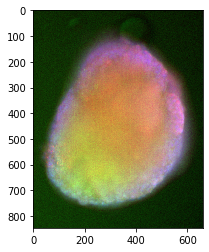

DAPI
1 regions


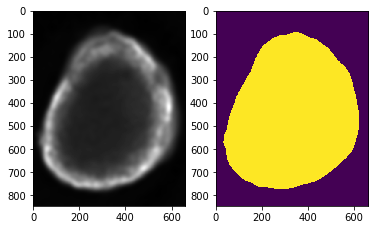

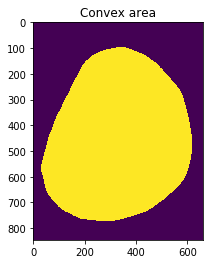

PAX6


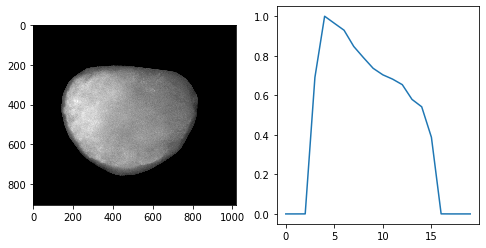

BRA


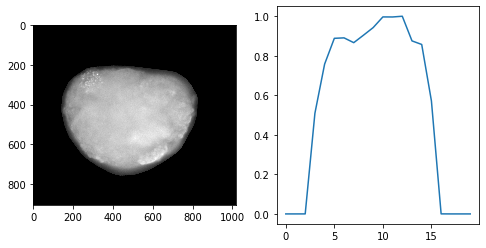

../data-Seb/SUMO3/D5_BRA_PAX6/10.tif
(3, 630, 564)


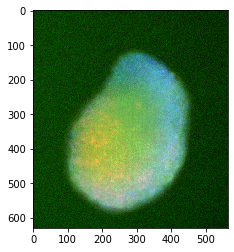

DAPI
1 regions


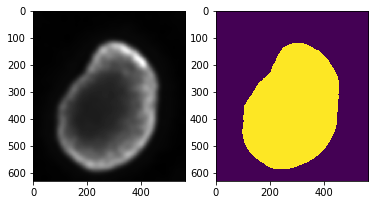

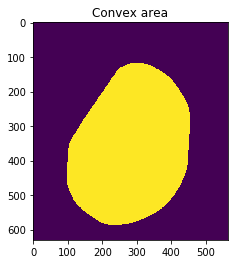

PAX6


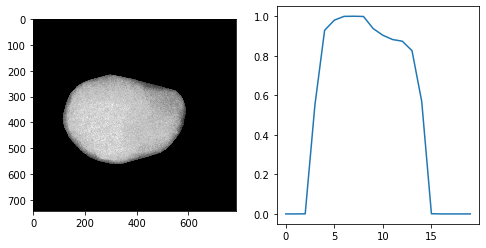

BRA


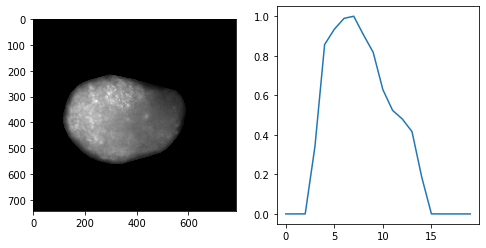

../data-Seb/SUMO3/D5_BRA_PAX6/11.tif
(3, 591, 612)


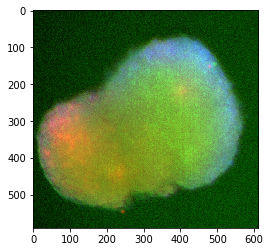

DAPI
2 regions


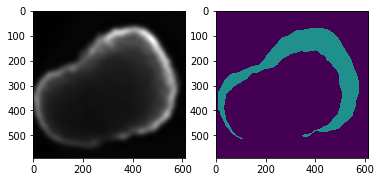

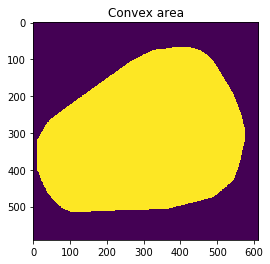

PAX6


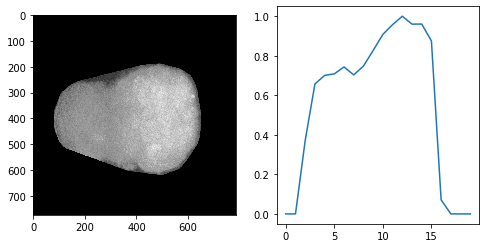

BRA


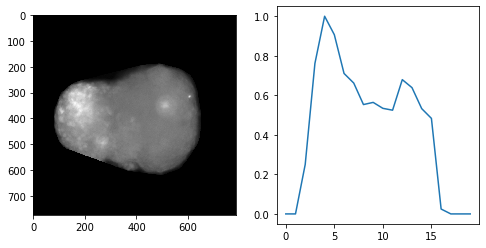

../data-Seb/SUMO3/D5_BRA_PAX6/12.tif
(3, 711, 591)


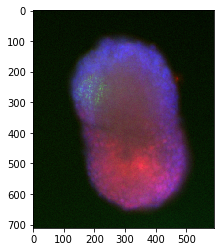

DAPI
1 regions


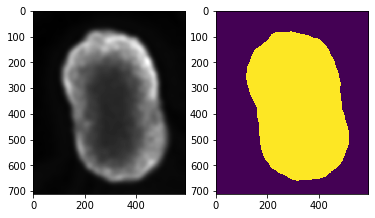

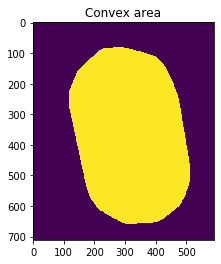

PAX6


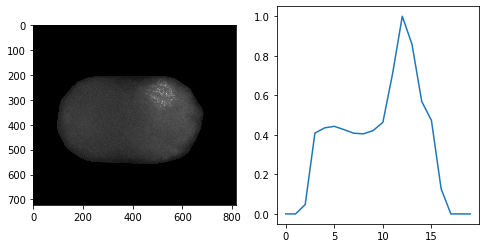

BRA


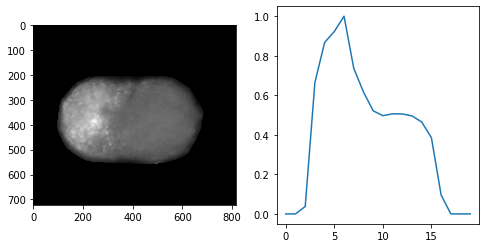

../data-Seb/SUMO3/D5_BRA_PAX6/13.tif
(3, 687, 1158)


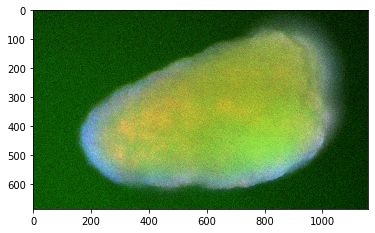

DAPI
1 regions


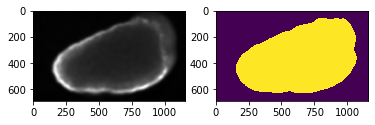

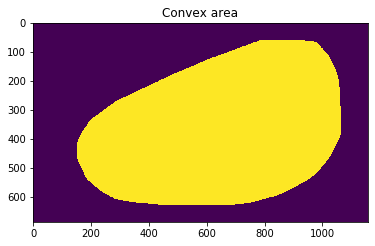

PAX6


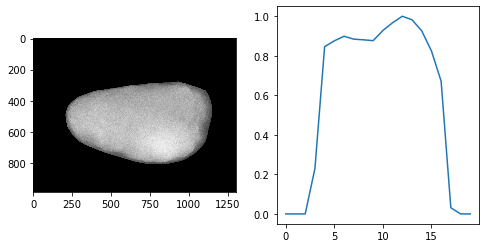

BRA


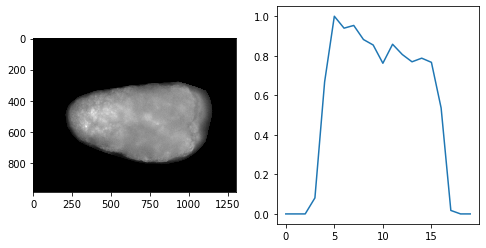

../data-Seb/SUMO3/D5_BRA_PAX6/14.tif
(3, 855, 732)


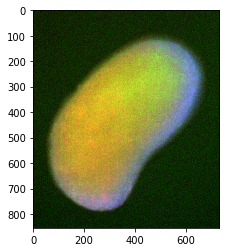

DAPI
1 regions


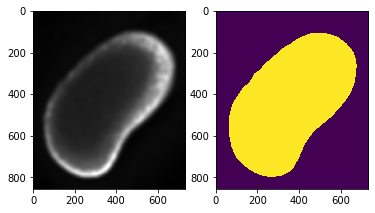

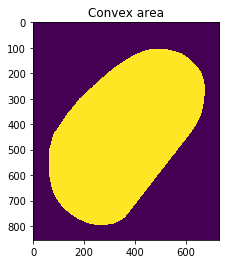

PAX6


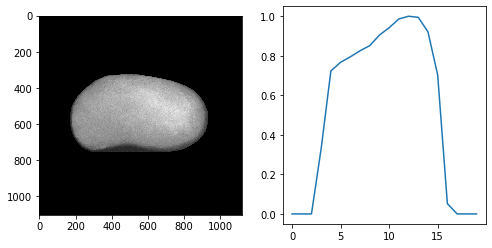

BRA


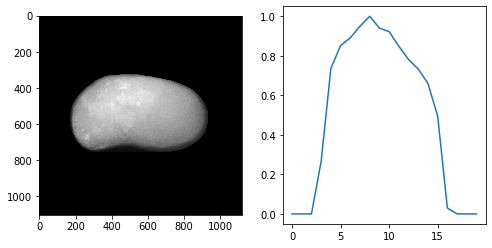

../data-Seb/SUMO3/D5_BRA_PAX6/2.tif
(3, 1164, 729)


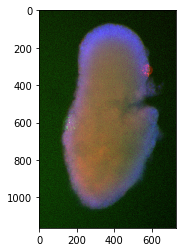

DAPI
1 regions


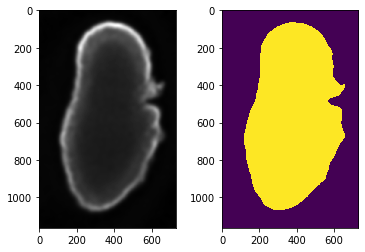

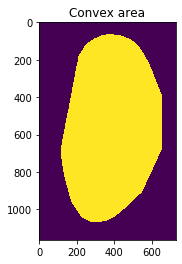

PAX6


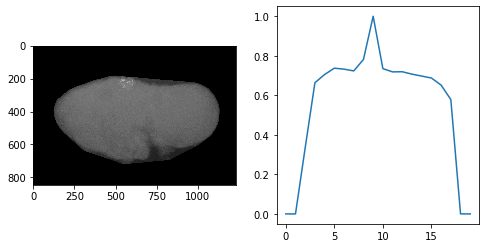

BRA


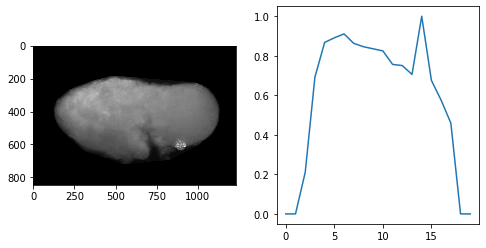

../data-Seb/SUMO3/D5_BRA_PAX6/3.tif
(3, 714, 729)


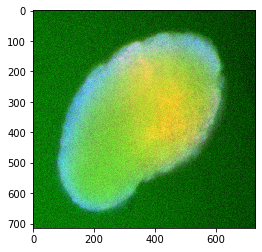

DAPI
1 regions


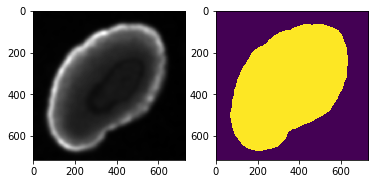

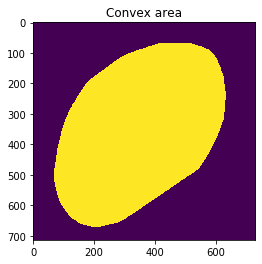

PAX6


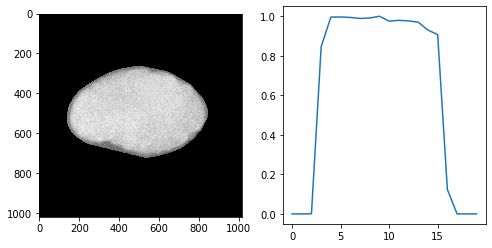

BRA


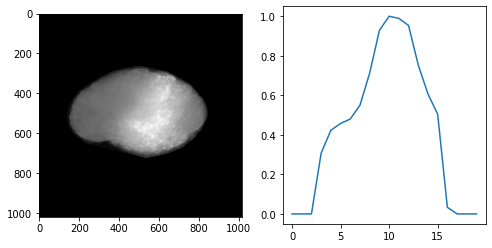

../data-Seb/SUMO3/D5_BRA_PAX6/4.tif
(3, 1101, 816)


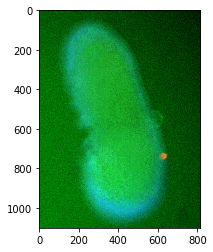

DAPI
1 regions


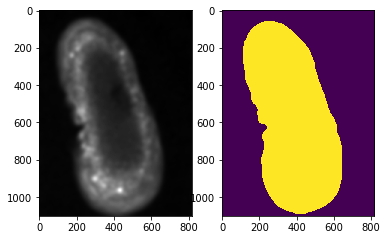

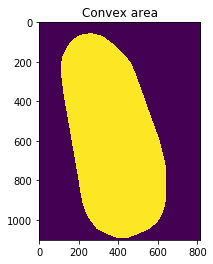

PAX6


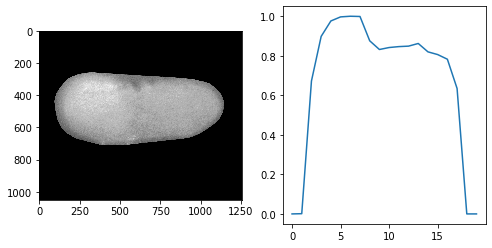

BRA


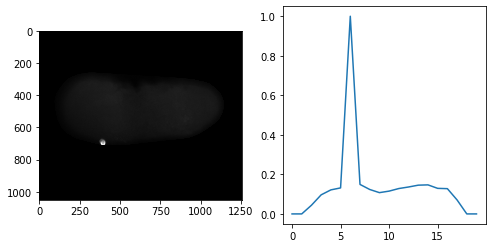

../data-Seb/SUMO3/D5_BRA_PAX6/5.tif
(3, 486, 399)


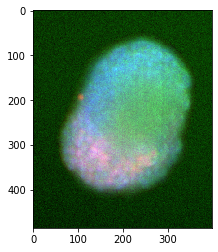

DAPI
1 regions


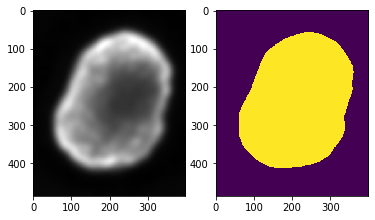

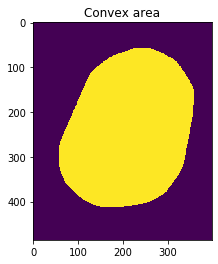

PAX6


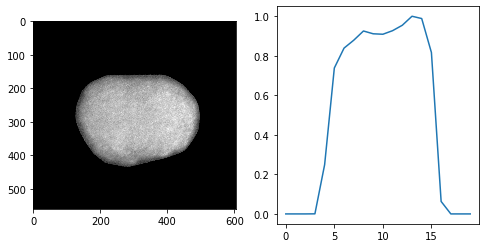

BRA


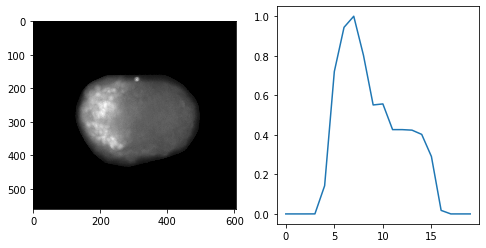

../data-Seb/SUMO3/D5_BRA_PAX6/6.tif
(3, 801, 639)


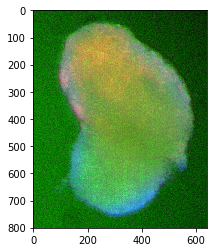

DAPI
1 regions


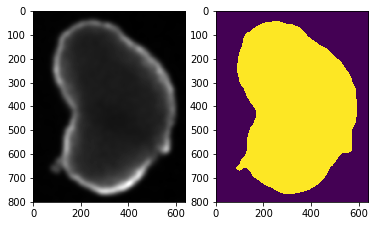

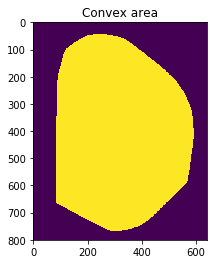

PAX6


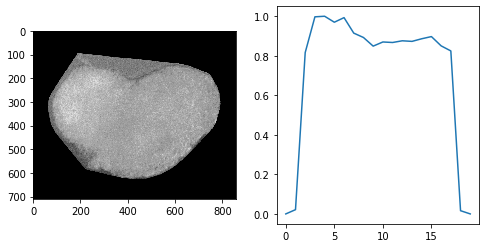

BRA


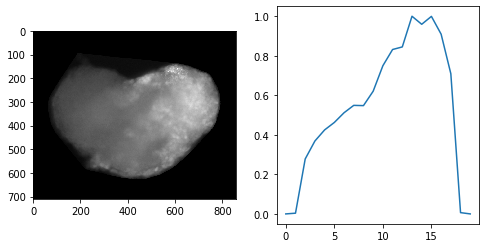

../data-Seb/SUMO3/D5_BRA_PAX6/7.tif
(3, 414, 384)


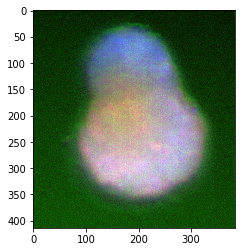

DAPI
1 regions


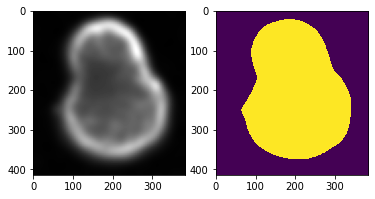

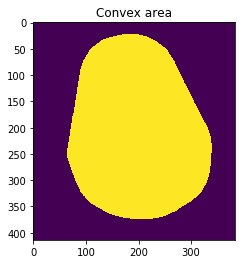

PAX6


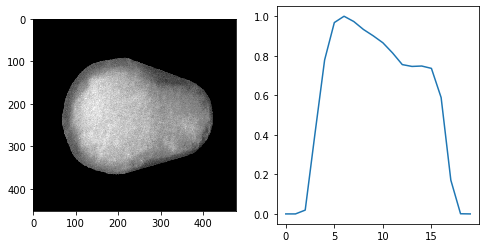

BRA


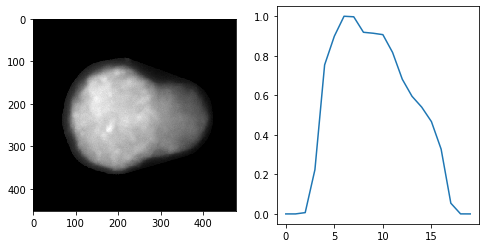

../data-Seb/SUMO3/D5_BRA_PAX6/8.tif
(3, 735, 873)


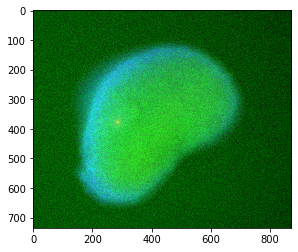

DAPI
1 regions


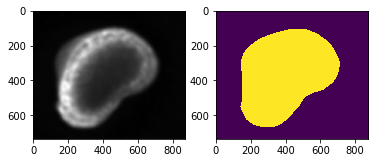

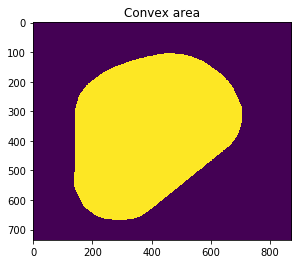

PAX6


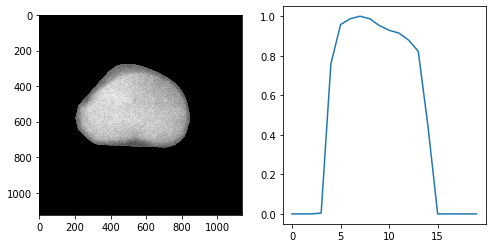

BRA


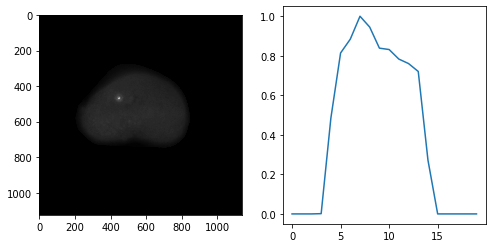

../data-Seb/SUMO3/D5_BRA_PAX6/9.tif
(3, 1041, 681)


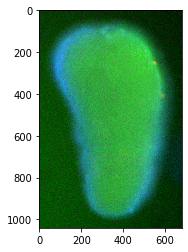

DAPI
1 regions


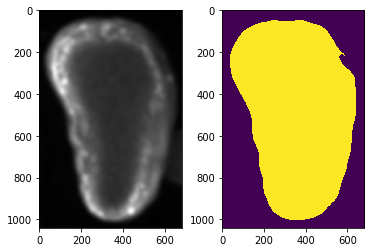

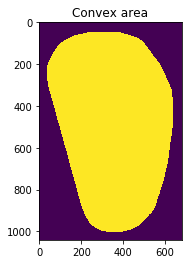

PAX6


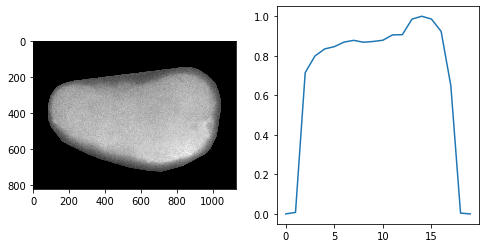

BRA


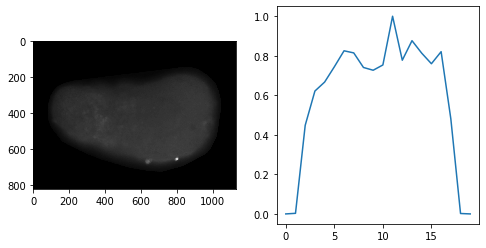

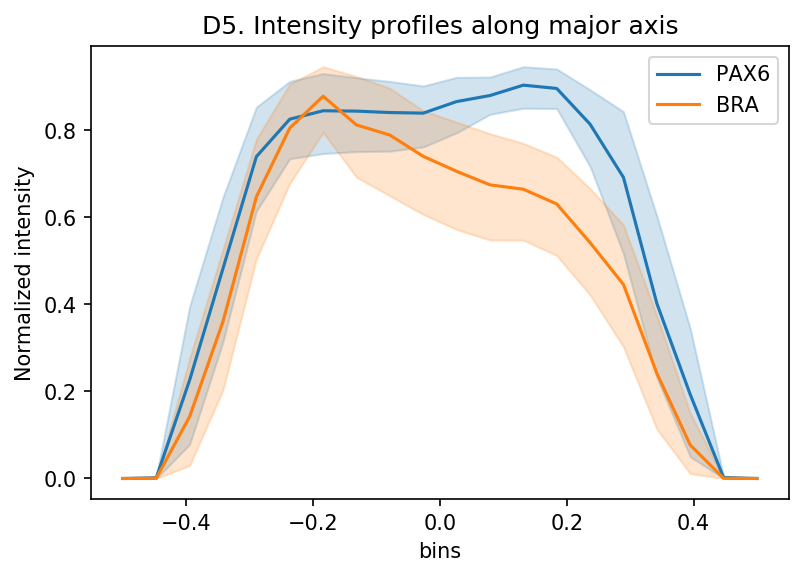

../data-Seb/SUMO3/D5_FOXA2_PAX6/
../data-Seb/SUMO3/D5_FOXA2_PAX6/1.tif
(3, 1062, 684)


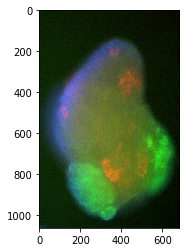

DAPI
8 regions


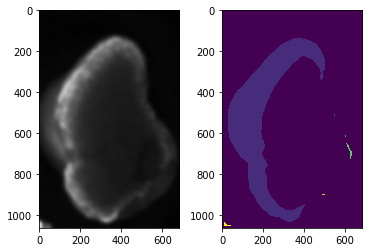

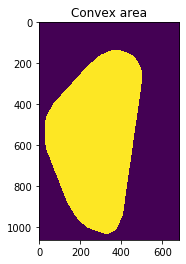

PAX6


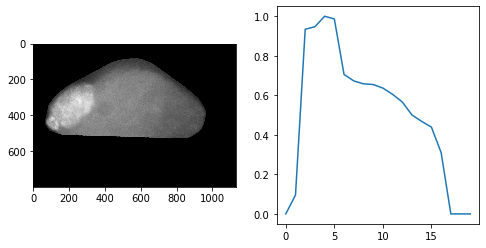

FOXA2


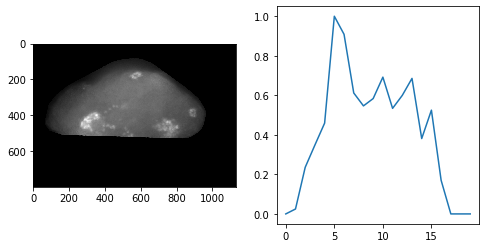

../data-Seb/SUMO3/D5_FOXA2_PAX6/10.tif
(3, 558, 576)


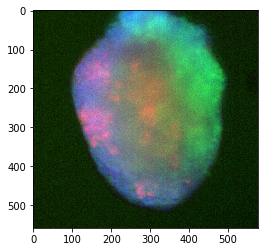

DAPI
1 regions


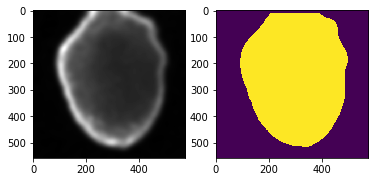

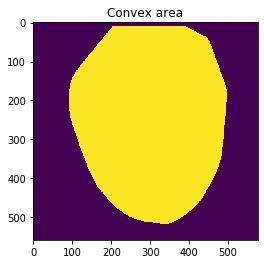

PAX6


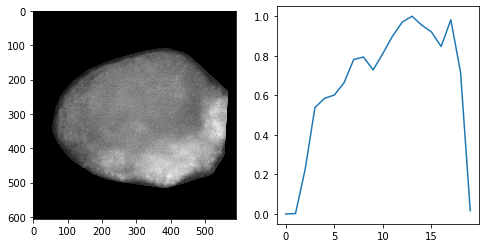

FOXA2


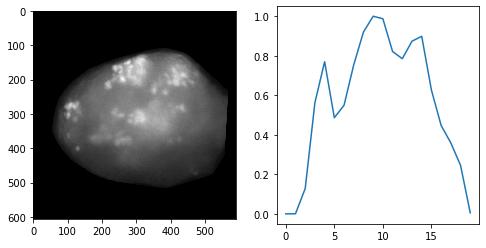

../data-Seb/SUMO3/D5_FOXA2_PAX6/11.tif
(3, 705, 729)


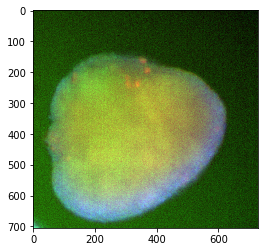

DAPI
2 regions


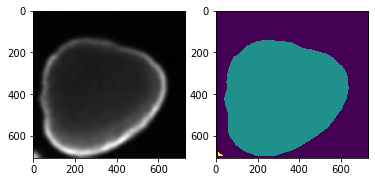

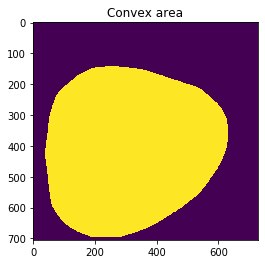

PAX6


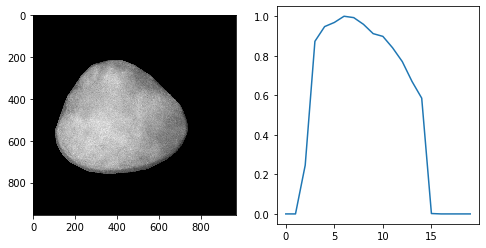

FOXA2


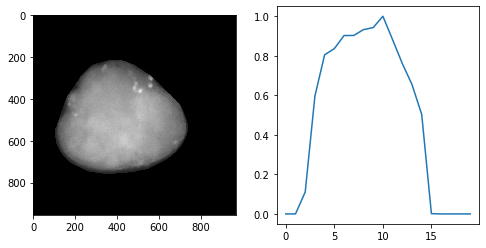

../data-Seb/SUMO3/D5_FOXA2_PAX6/12.tif
(3, 633, 1107)


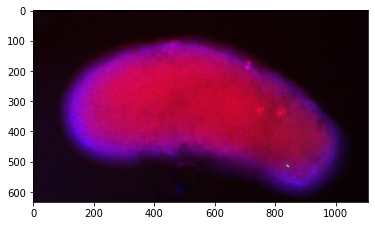

DAPI
2 regions


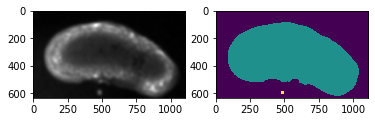

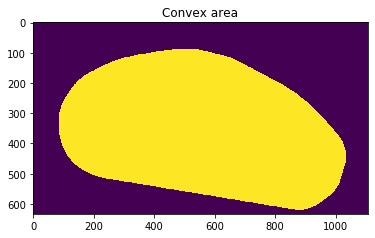

PAX6


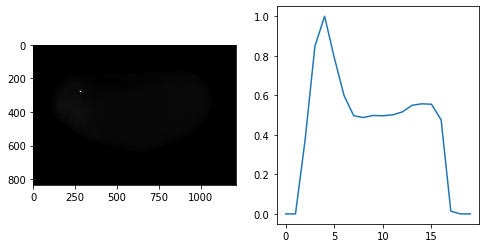

FOXA2


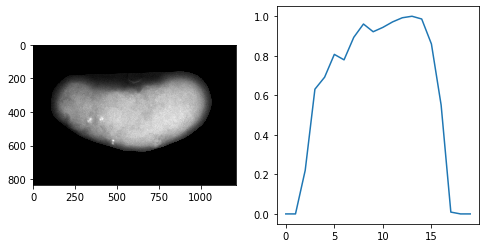

../data-Seb/SUMO3/D5_FOXA2_PAX6/13.tif
(3, 723, 969)


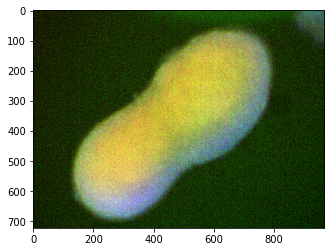

DAPI
3 regions


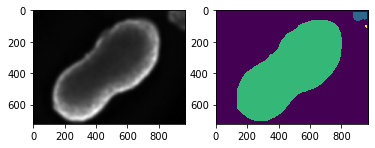

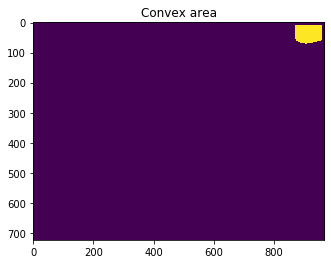

PAX6


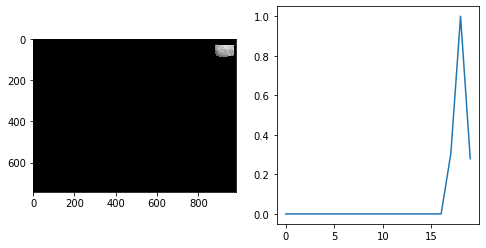

FOXA2


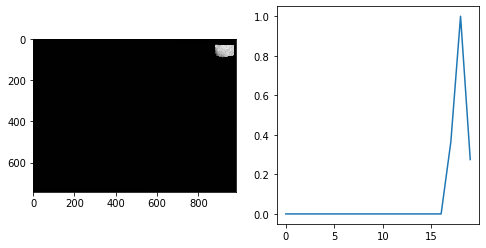

../data-Seb/SUMO3/D5_FOXA2_PAX6/14.tif
(3, 765, 894)


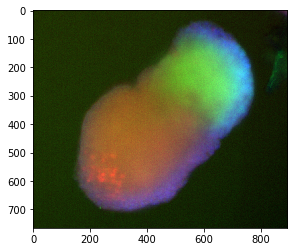

DAPI
7 regions


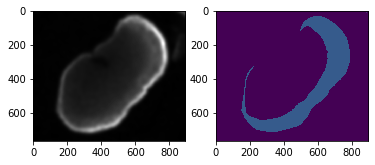

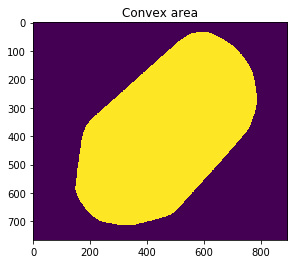

PAX6


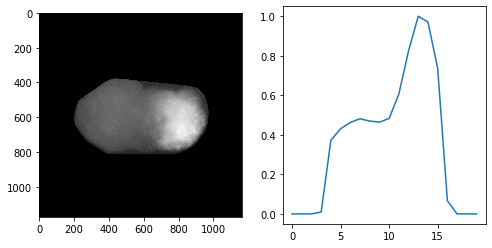

FOXA2


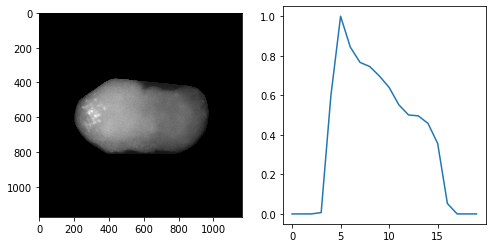

../data-Seb/SUMO3/D5_FOXA2_PAX6/15.tif
(3, 750, 954)


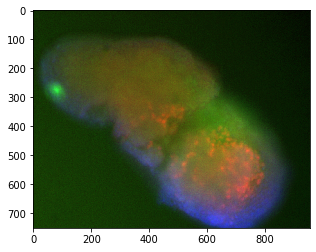

DAPI
2 regions


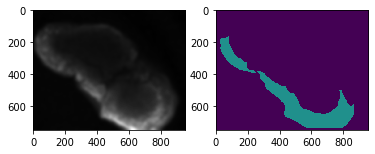

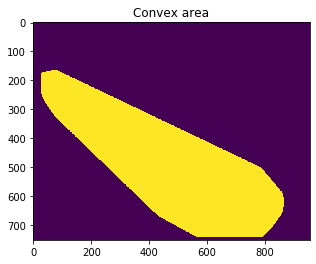

PAX6


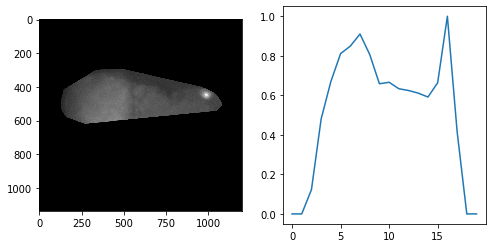

FOXA2


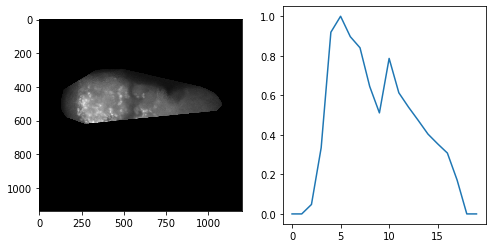

../data-Seb/SUMO3/D5_FOXA2_PAX6/2.tif
(3, 846, 693)


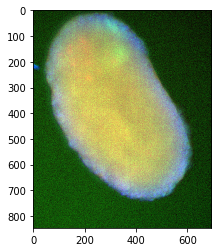

DAPI
1 regions


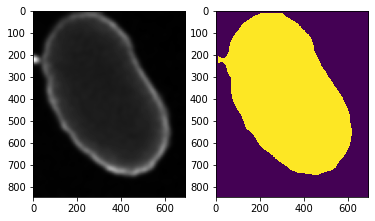

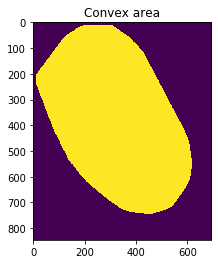

PAX6


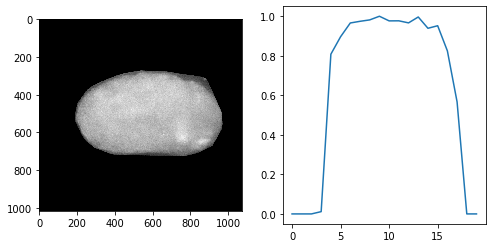

FOXA2


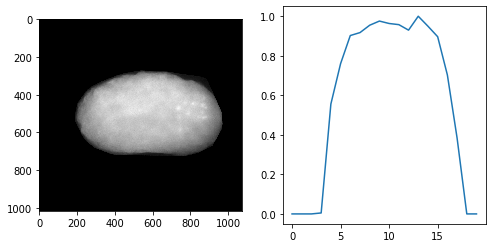

../data-Seb/SUMO3/D5_FOXA2_PAX6/3.tif
(3, 594, 660)


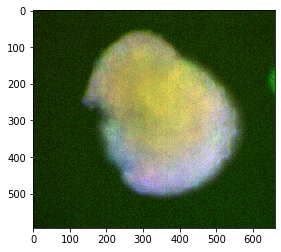

DAPI
1 regions


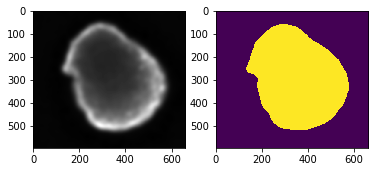

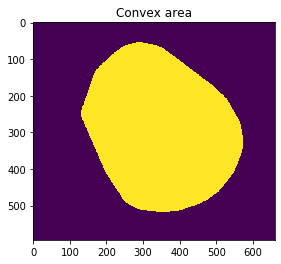

PAX6


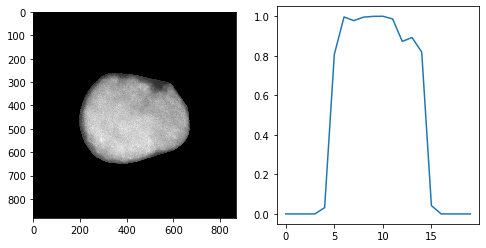

FOXA2


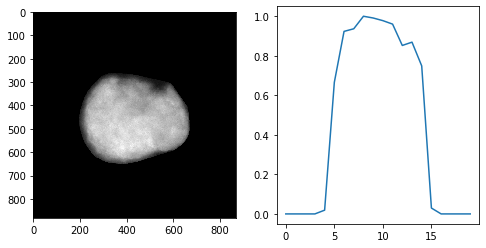

../data-Seb/SUMO3/D5_FOXA2_PAX6/4.tif
(3, 954, 822)


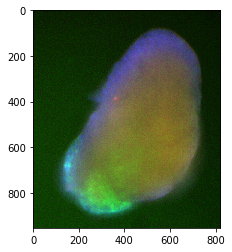

DAPI
1 regions


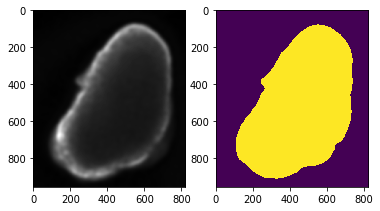

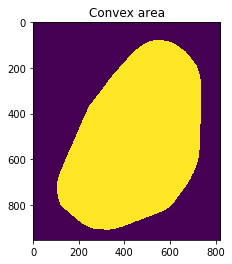

PAX6


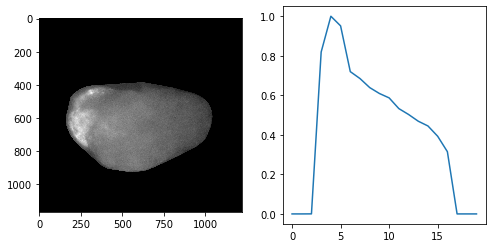

FOXA2


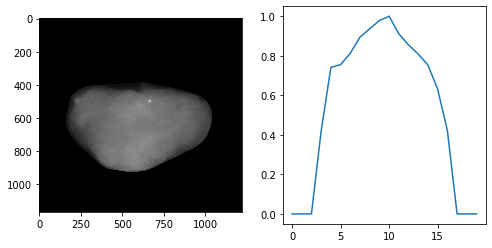

../data-Seb/SUMO3/D5_FOXA2_PAX6/5.tif
(3, 612, 498)


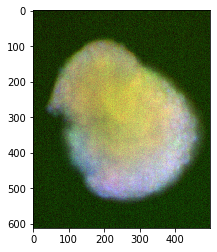

DAPI
1 regions


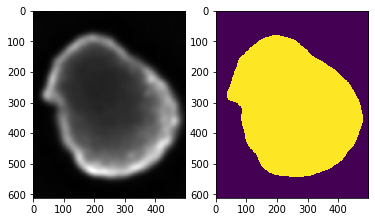

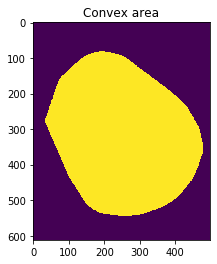

PAX6


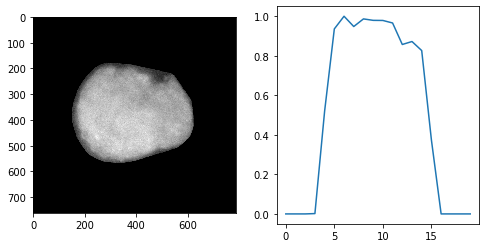

FOXA2


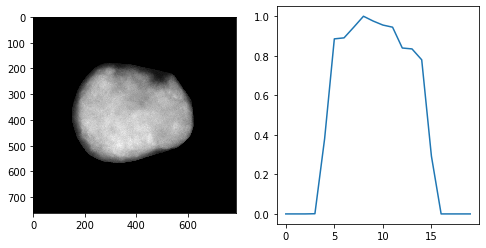

../data-Seb/SUMO3/D5_FOXA2_PAX6/6.tif
(3, 537, 675)


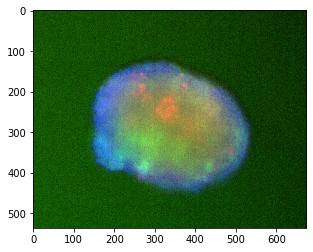

DAPI
1 regions


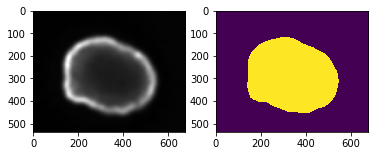

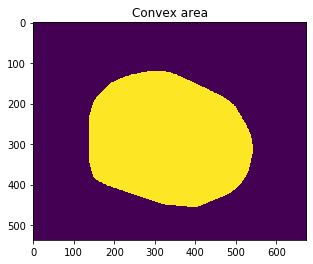

PAX6


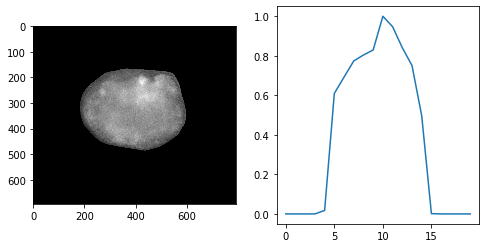

FOXA2


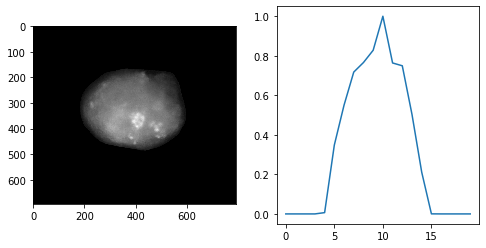

../data-Seb/SUMO3/D5_FOXA2_PAX6/7.tif
(3, 636, 963)


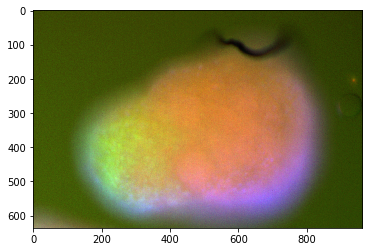

DAPI
2 regions


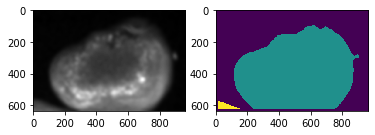

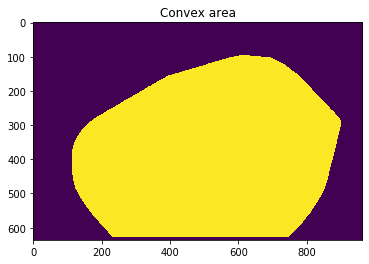

PAX6


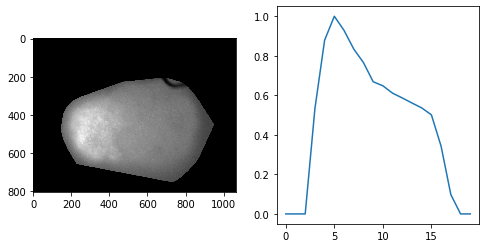

FOXA2


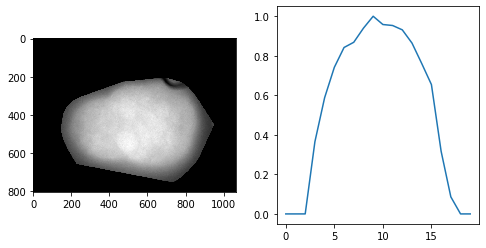

../data-Seb/SUMO3/D5_FOXA2_PAX6/8.tif
(3, 774, 807)


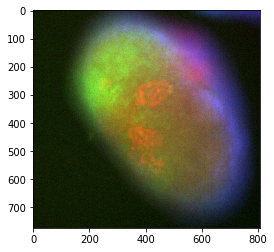

DAPI
1 regions


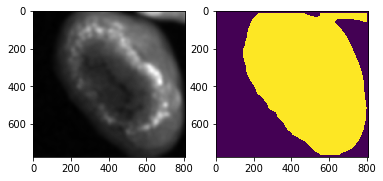

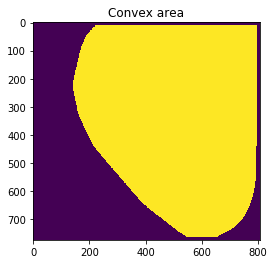

PAX6


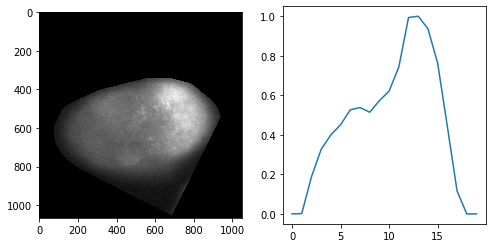

FOXA2


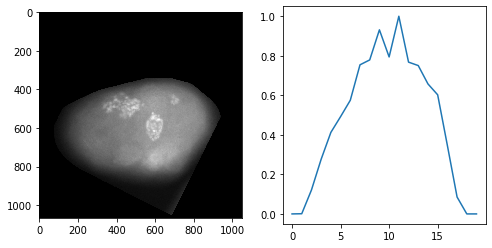

../data-Seb/SUMO3/D5_FOXA2_PAX6/9.tif
(3, 672, 1017)


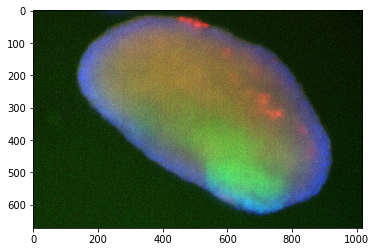

DAPI
1 regions


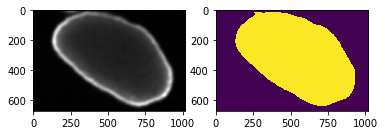

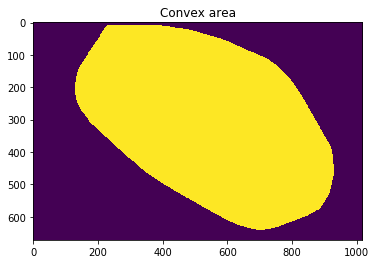

PAX6


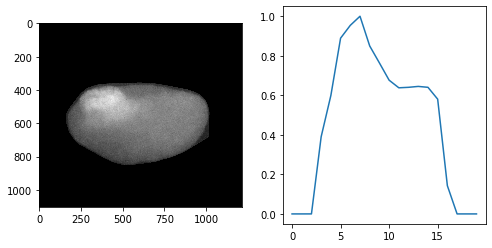

FOXA2


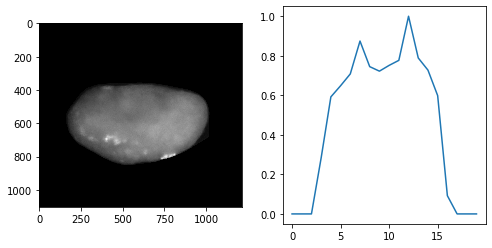

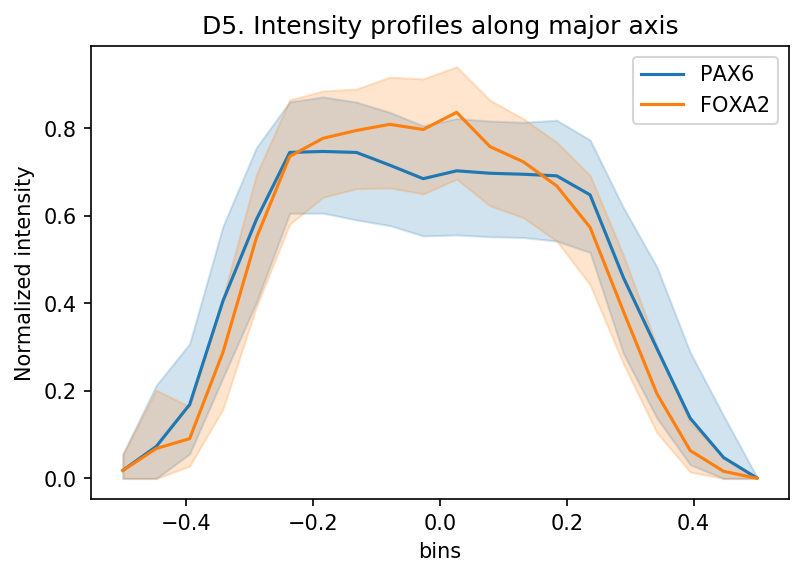

In [231]:
all_profiles = pd.DataFrame()
for f in ['../data-Seb/SUMO3/D5_BRA_PAX6/',
 '../data-Seb/SUMO3/D5_FOXA2_PAX6/']:
    print(f)
    [(day, p1, p2)] = r.findall(f)
    flist = glob(f+'*.tif')
    profiles = list(
        map(
            lambda path: process_3_colors(
                read_tif(path), 
                staining=[p2, p1]), flist))
    df = pd.concat(profiles)

    plt.subplots(dpi=150)
    sns.lineplot(x='bins', y=p2, data=df, label=p2)
    sns.lineplot(x='bins', y=p1, data=df, label=p1)
    plt.legend()
    plt.ylabel('Normalized intensity')
    plt.title(f'{day}. Intensity profiles along major axis')
    plt.show()
    
    all_profiles = pd.concat([all_profiles, df])
    